In [1]:
import numpy as np # linear algebra

In [2]:
%cd "Upernet"

/home/work2/Workspace/sonnh/do_an_test/Upernet


In [3]:
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from models import upernet_convnext_improved

2024-06-16 02:30:30.501459: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 02:30:30.520512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 02:30:30.520532: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 02:30:30.520542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-16 02:30:30.524239: I tensorflow/core/platform/cpu_feature_g

In [4]:
save_train_image_dataset_path = '../bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = '../bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = '../bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = '../bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = '../bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = '../bk-isut-dataset/mask_test_image_dataset.npy'

In [5]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [6]:
import albumentations as A

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [7]:
os.environ["SM_FRAMEWORK"] = "tf.keras" 
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [8]:
checkpoint_path = "../weights/imgnet_augmented_upernet_convnext_improved/cp.weights.h5"

In [9]:
model = upernet_convnext_improved.UPerNet(input_shape = (256,256,3), num_classes = 5)
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

2024-06-16 02:30:39.961197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 02:30:39.963914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 02:30:39.963995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
model.load_weights(checkpoint_path)

1/1 [==============================] - 0s 27ms/step


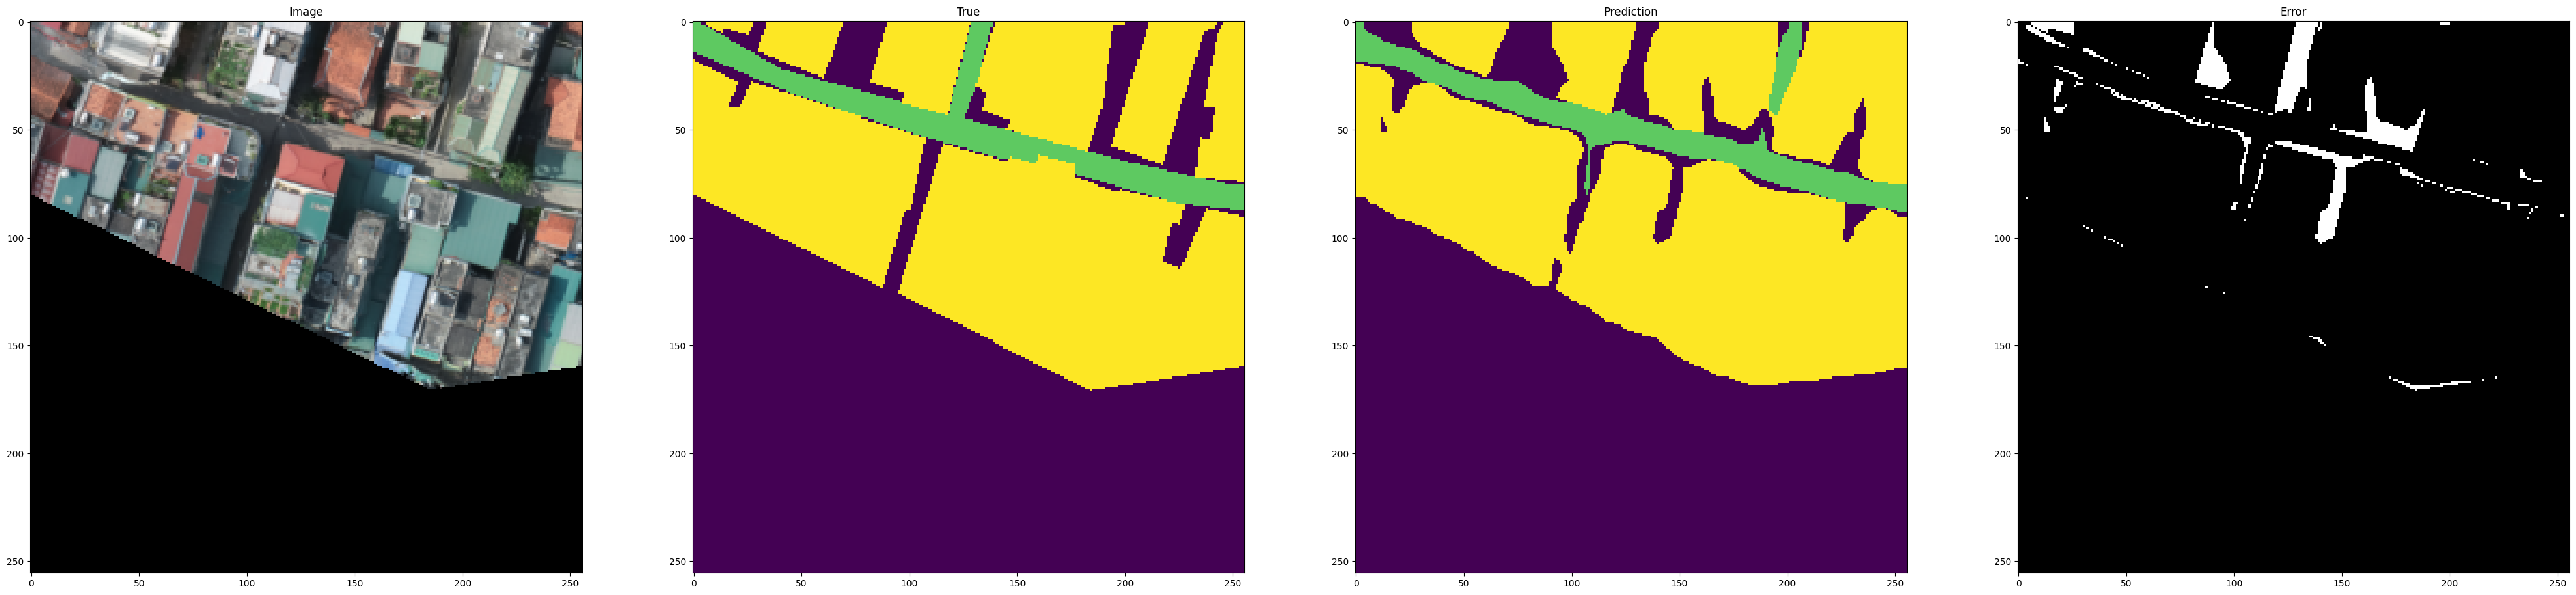

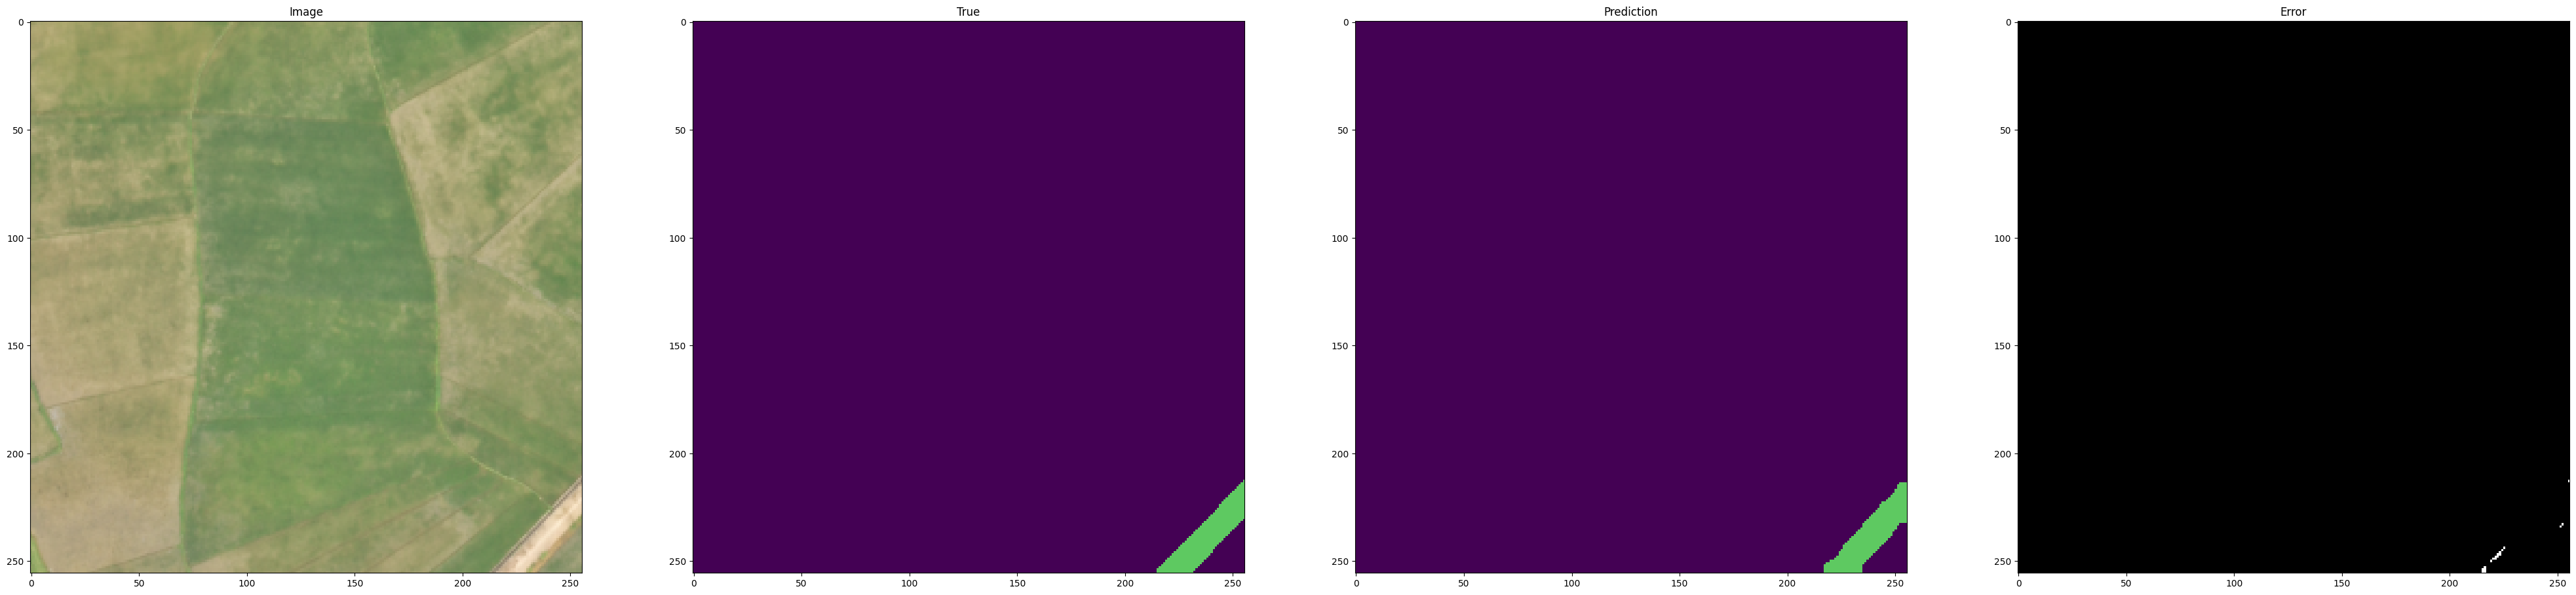

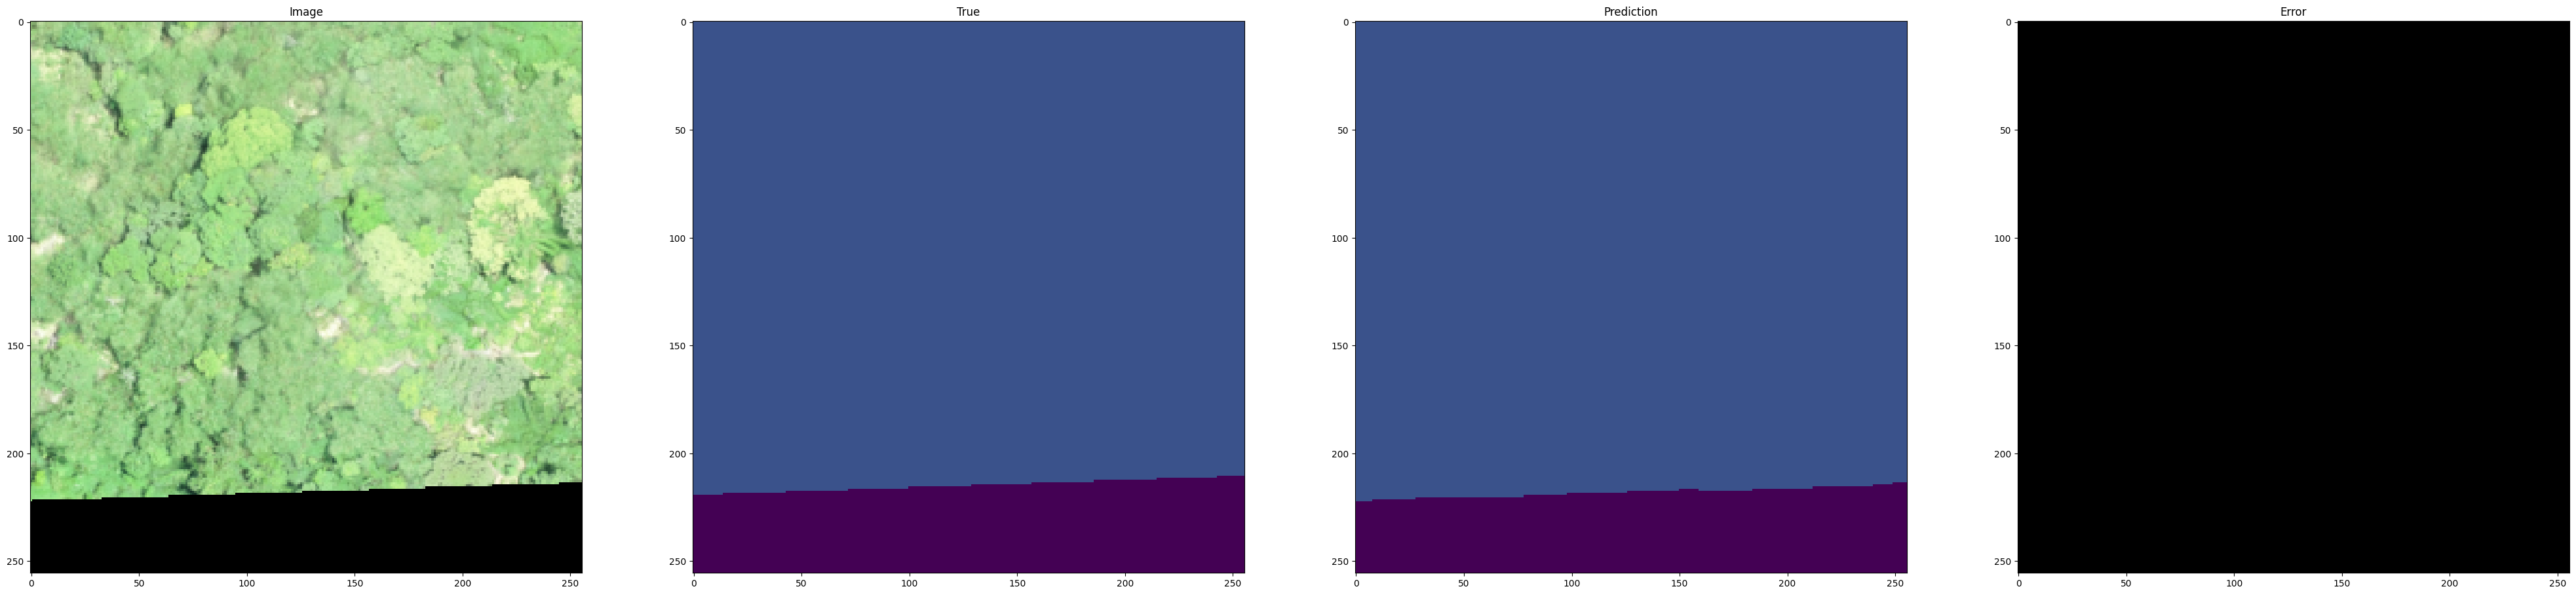

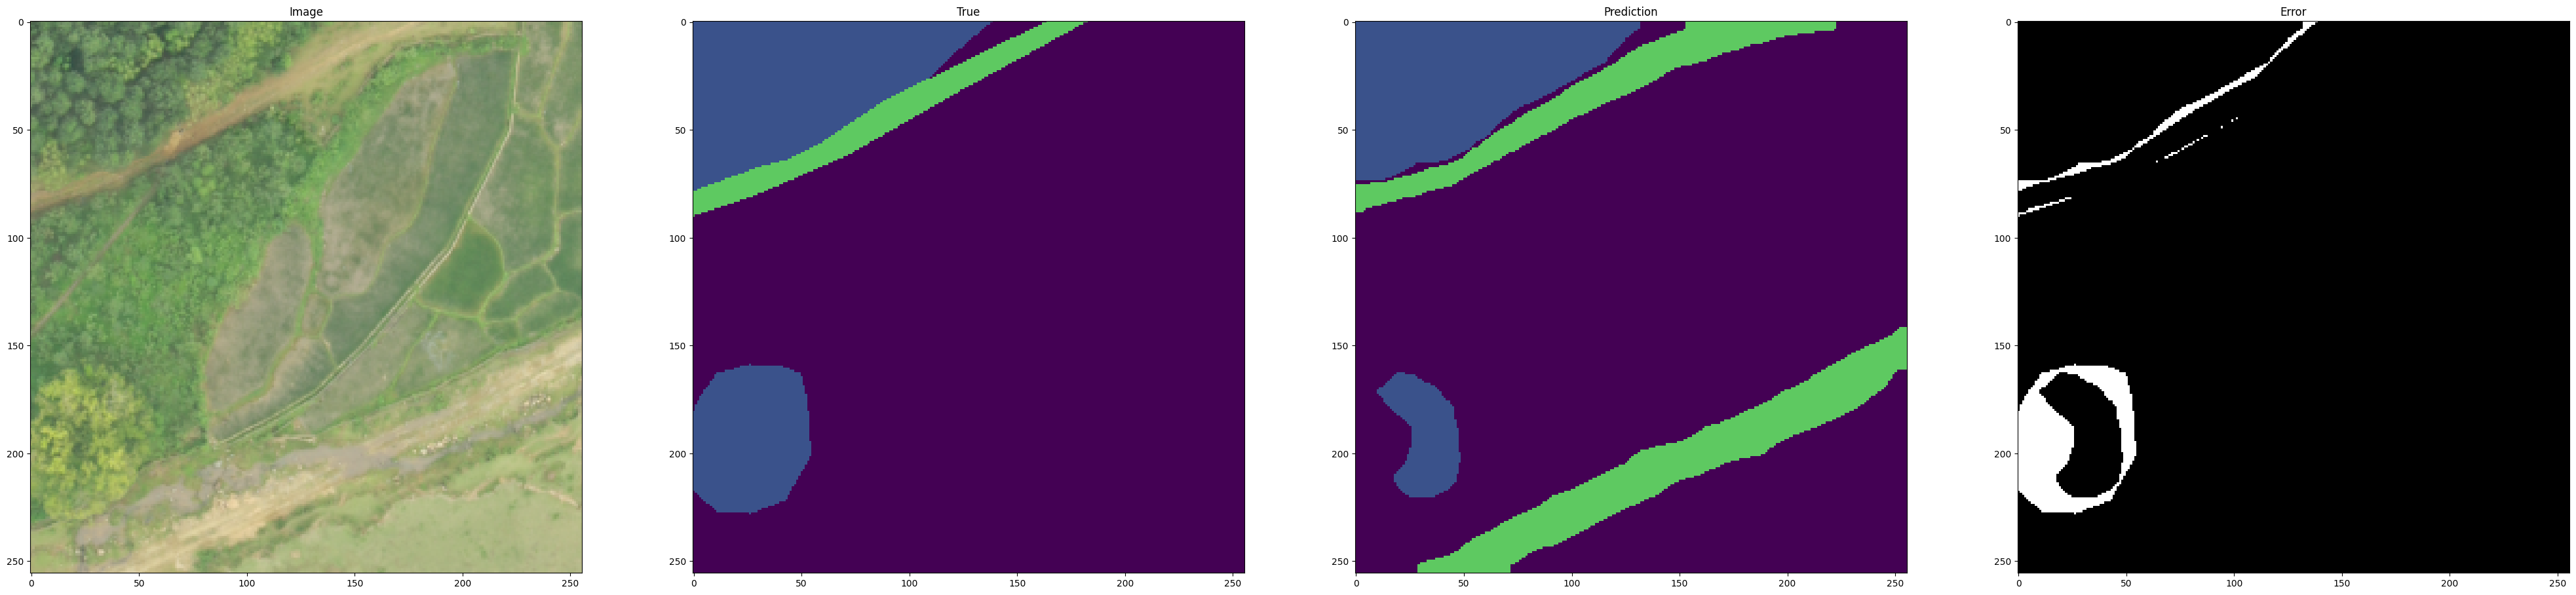

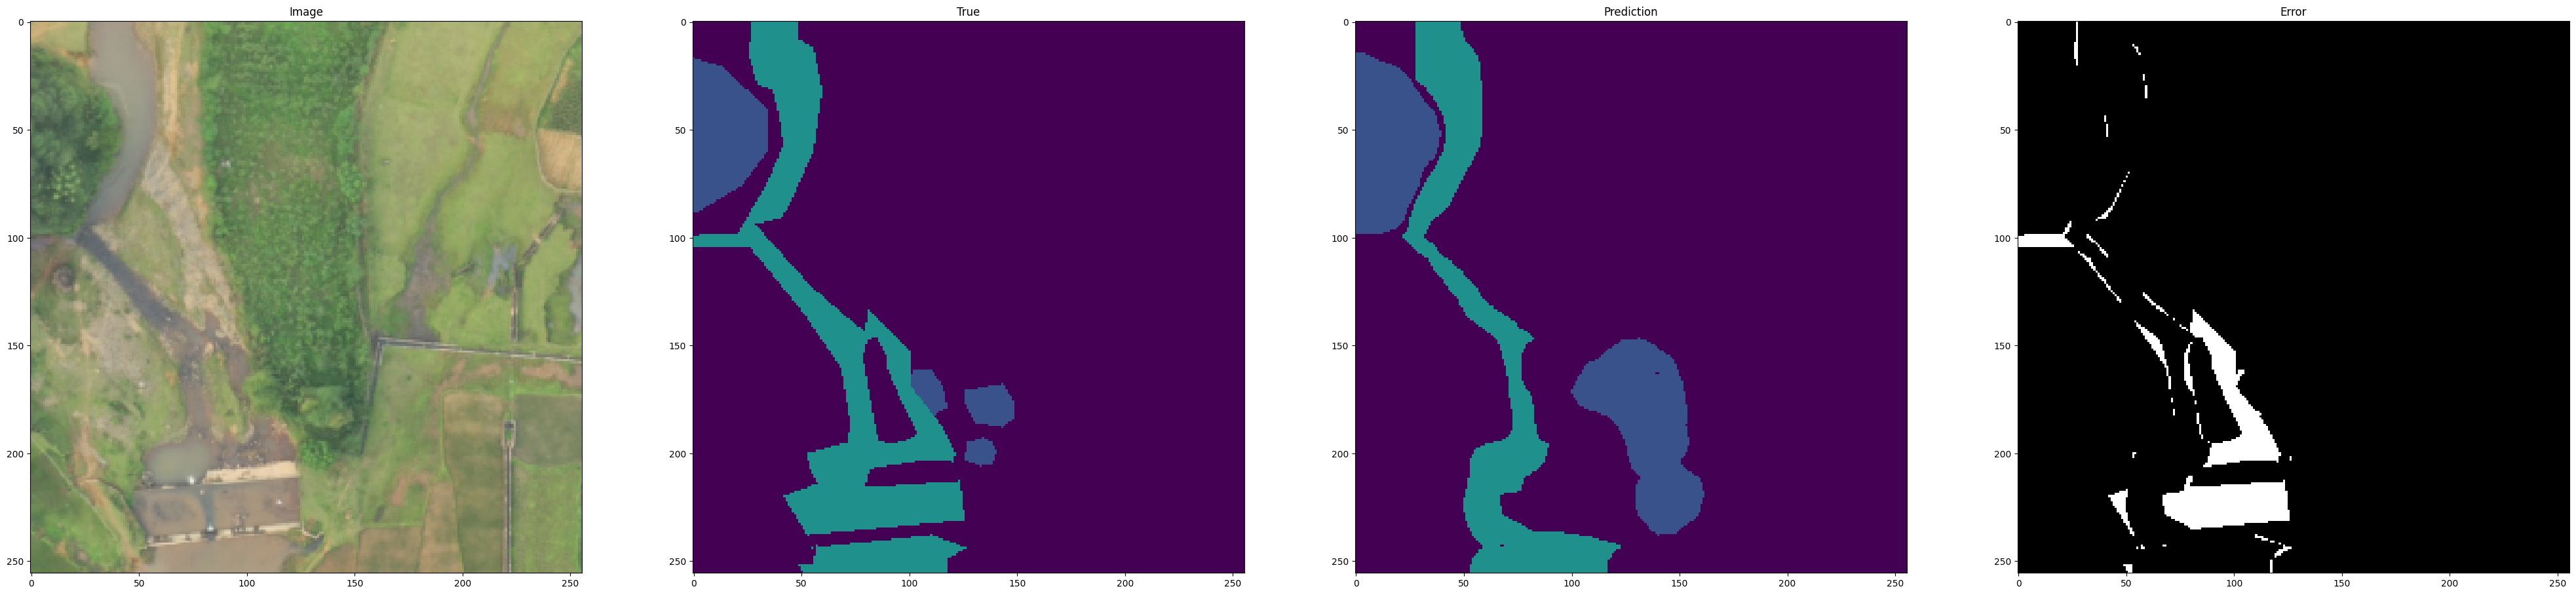

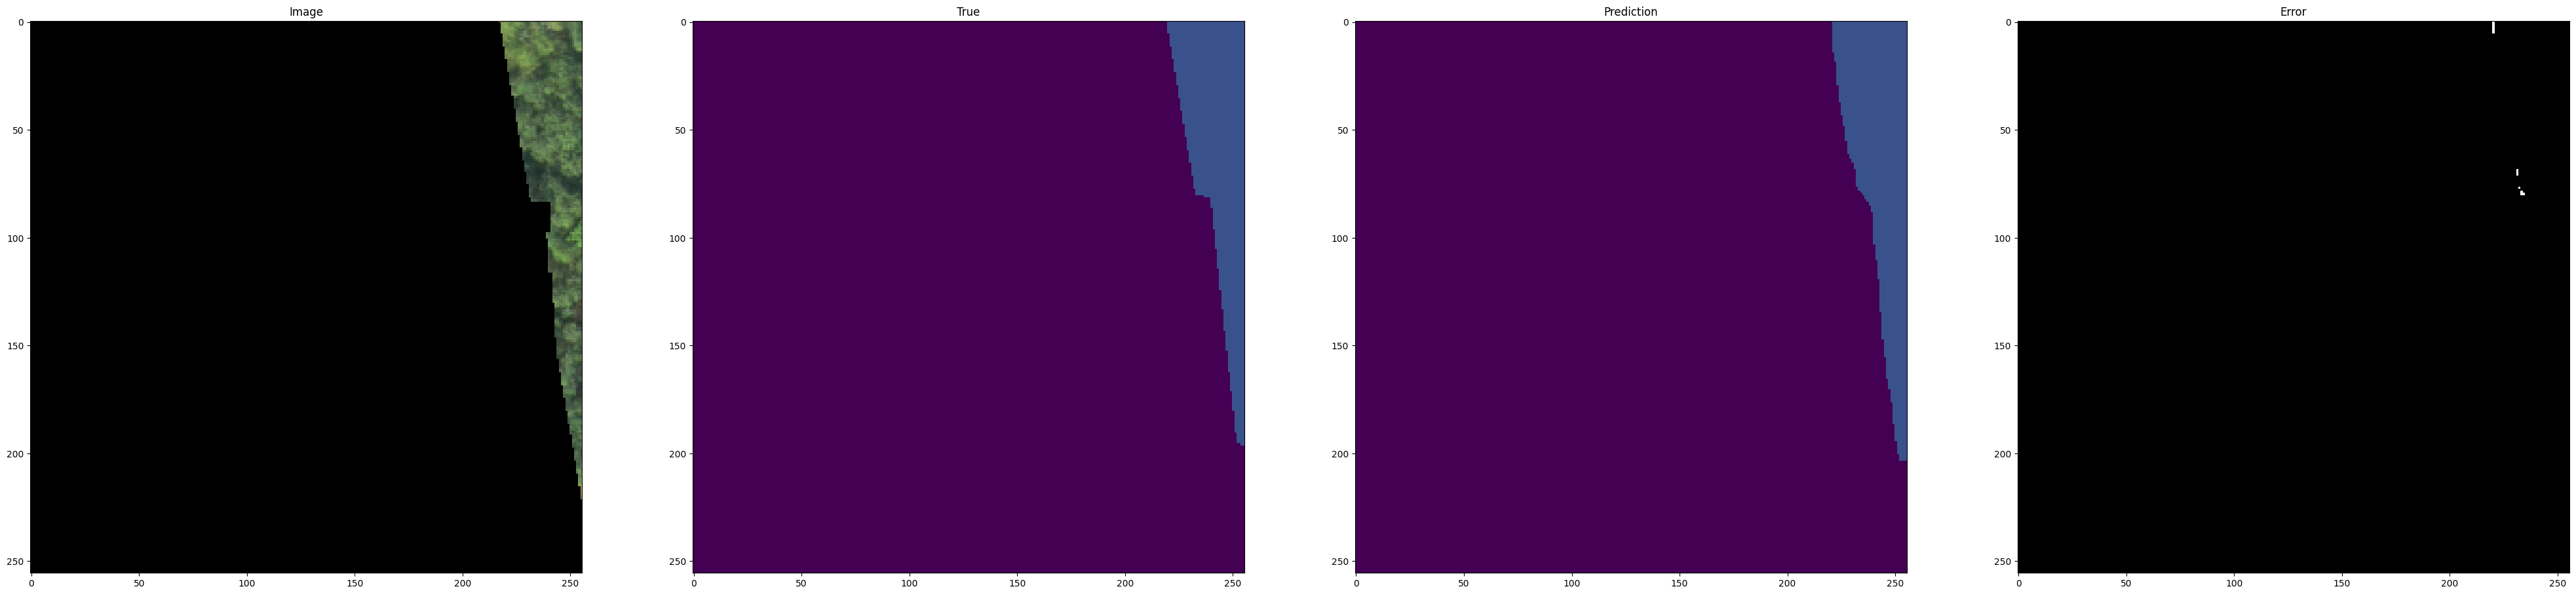

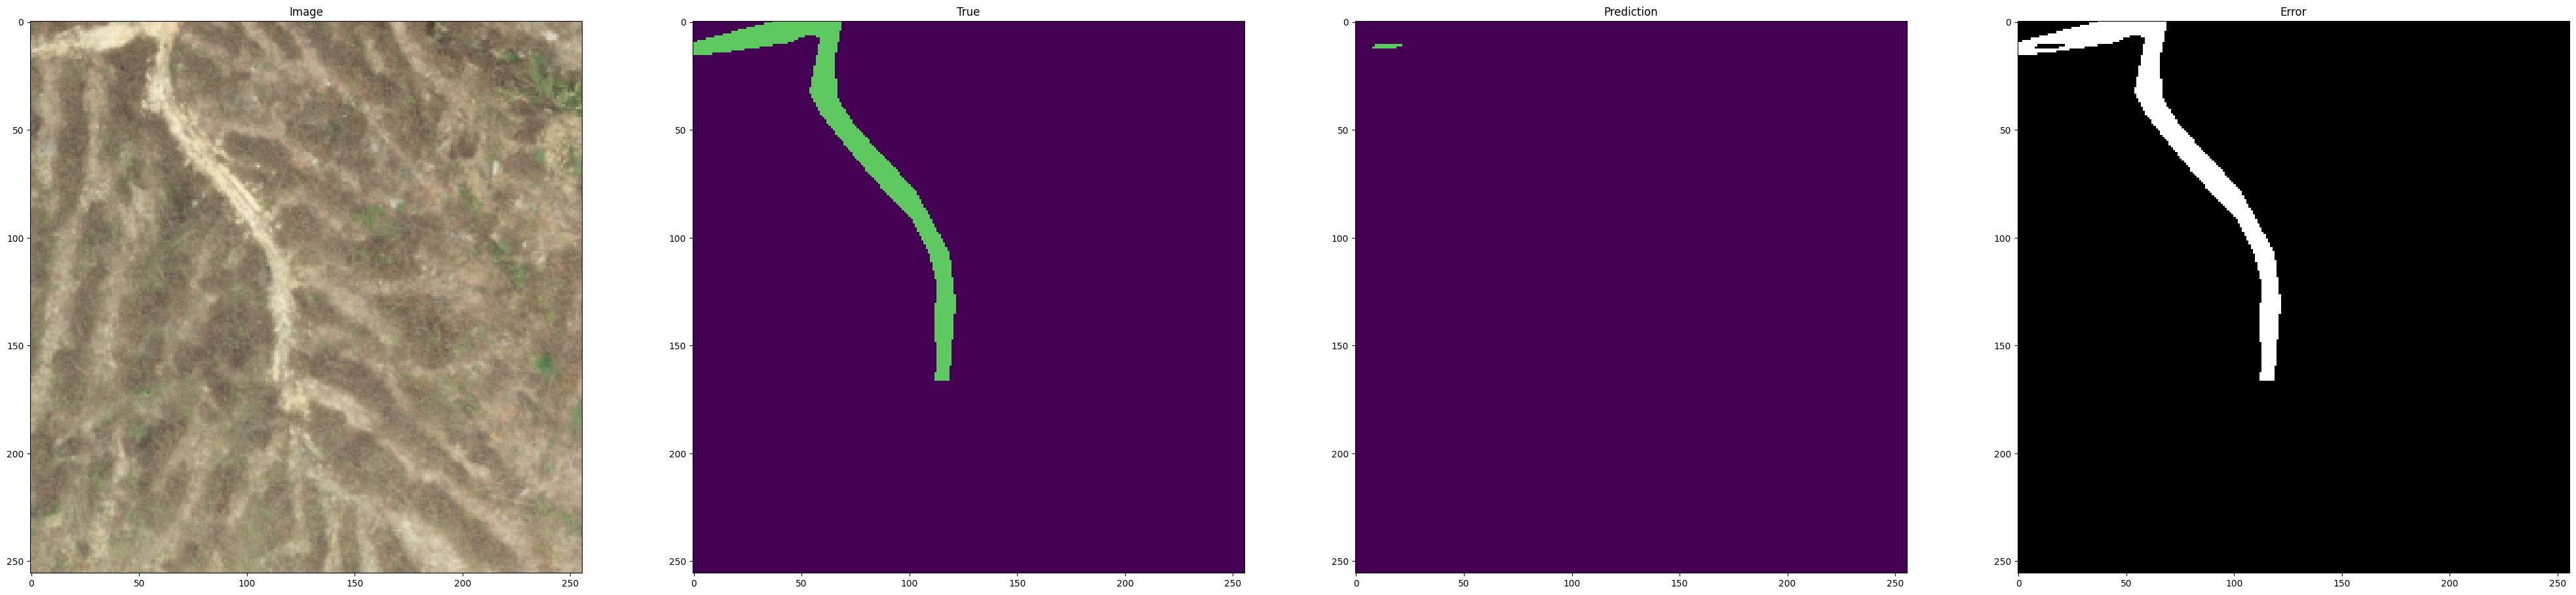

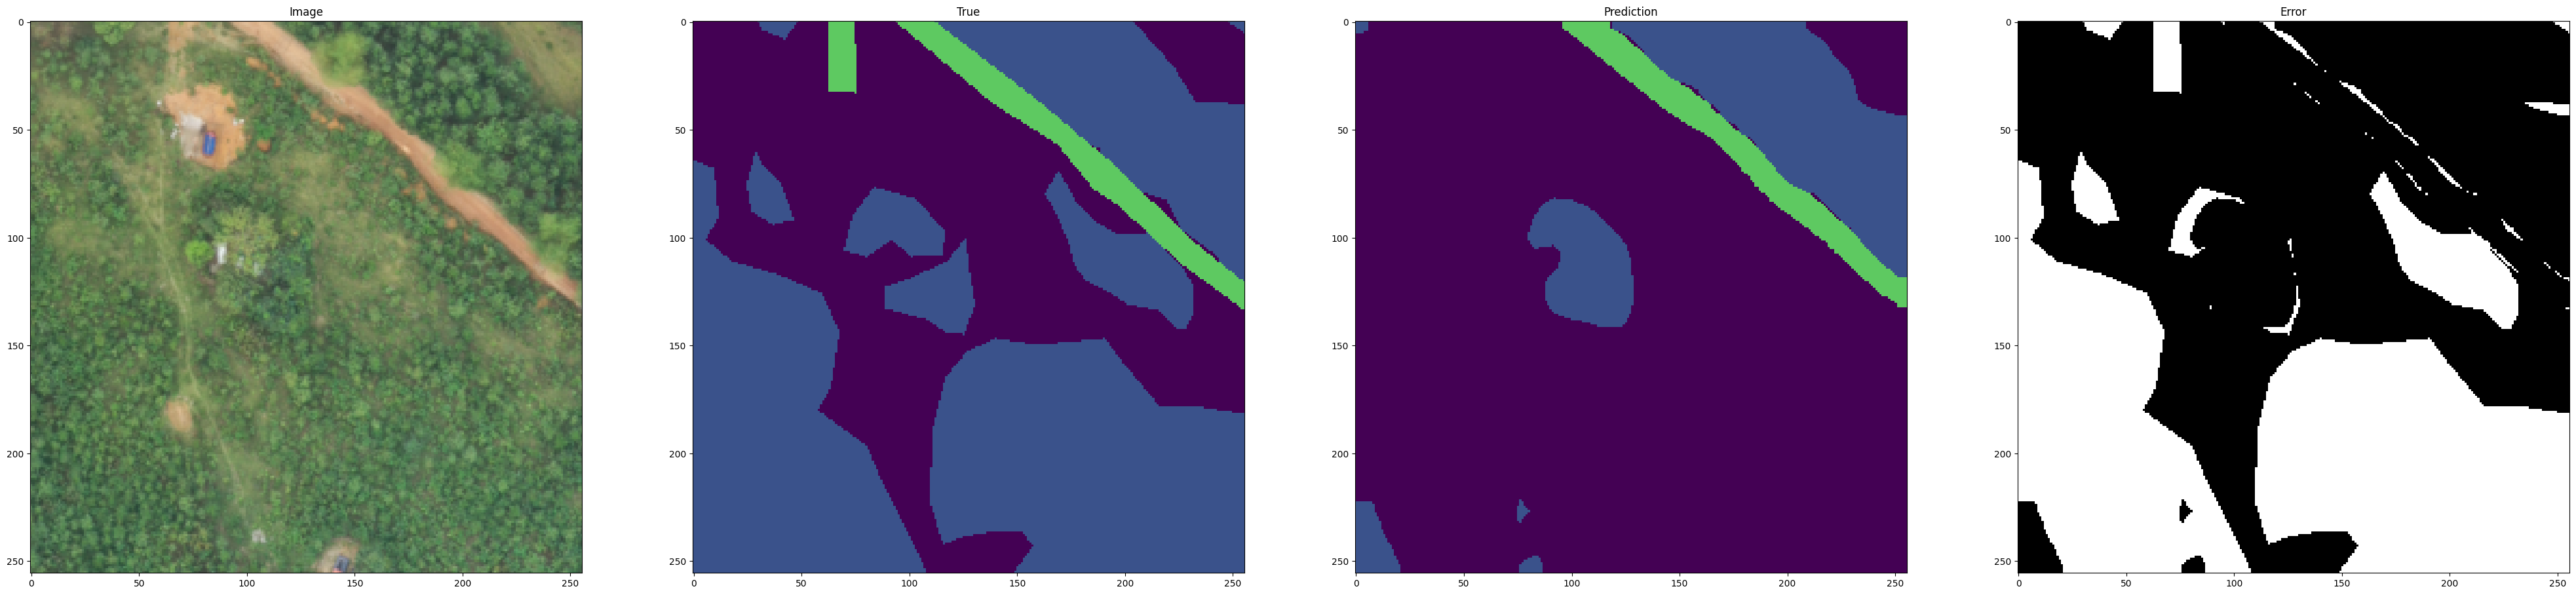

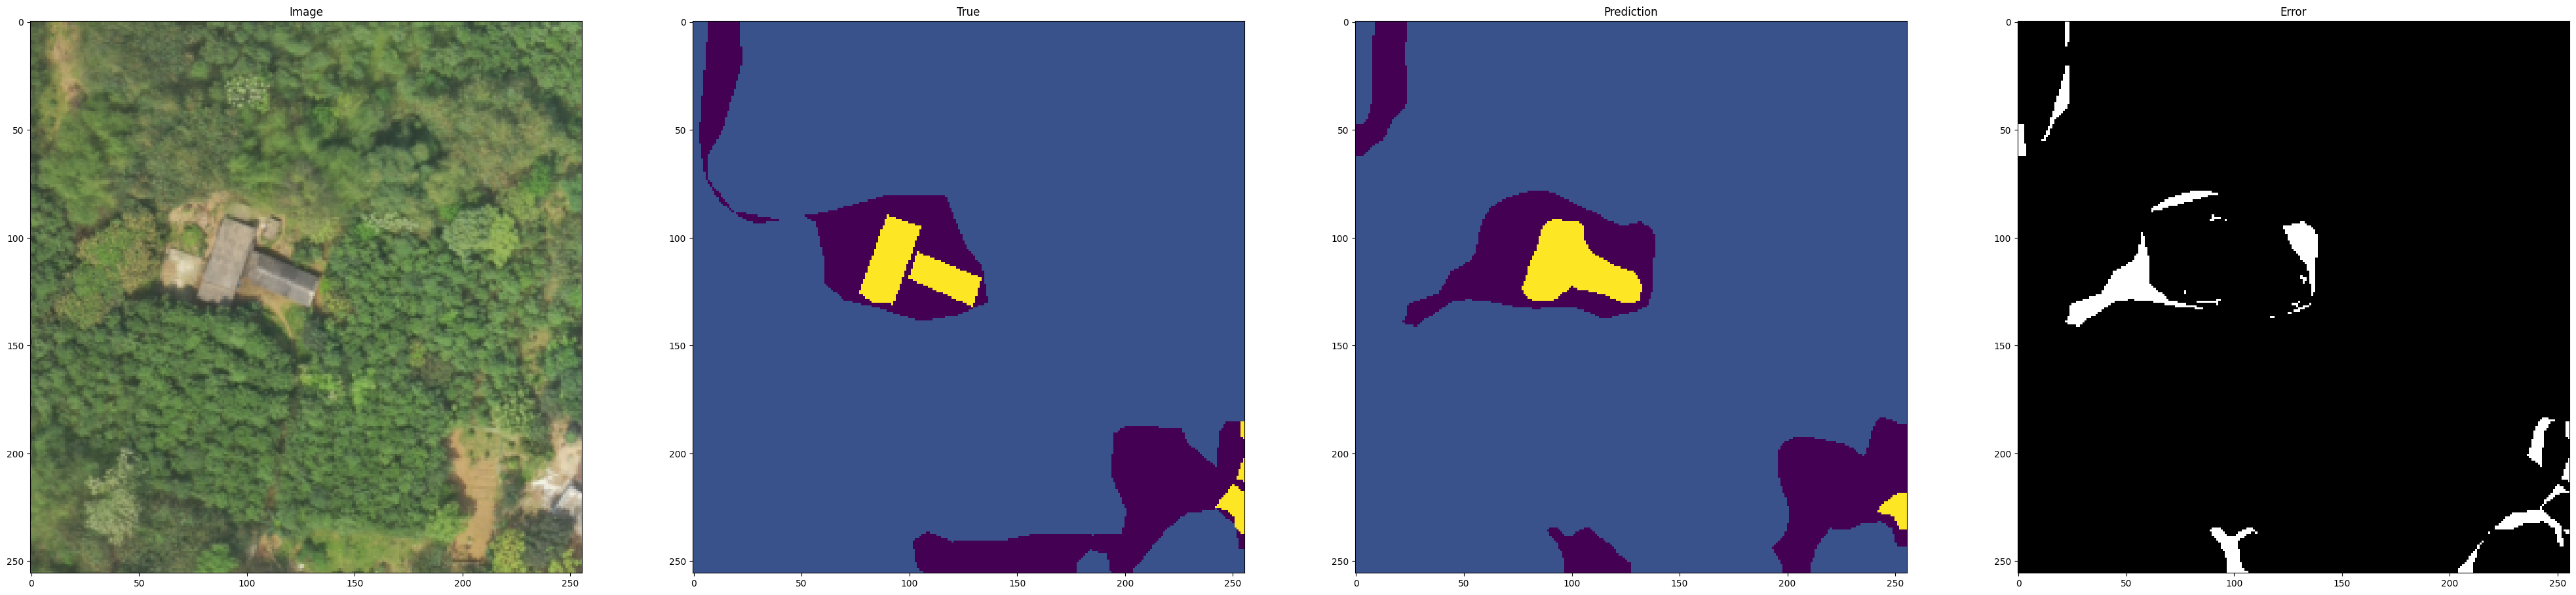

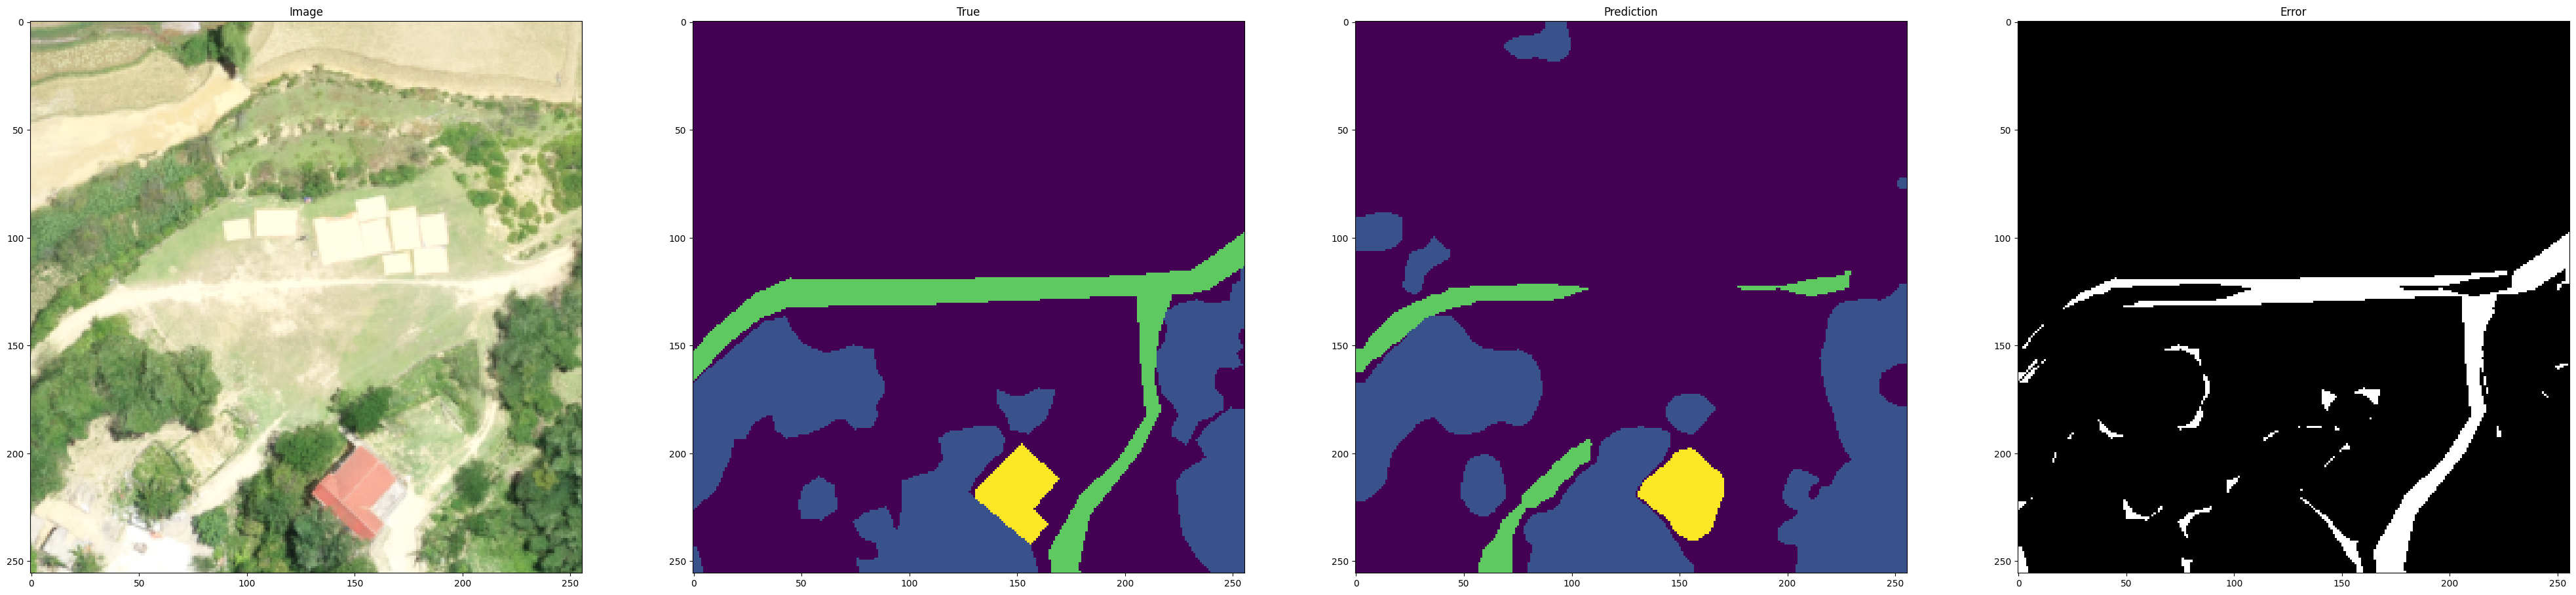

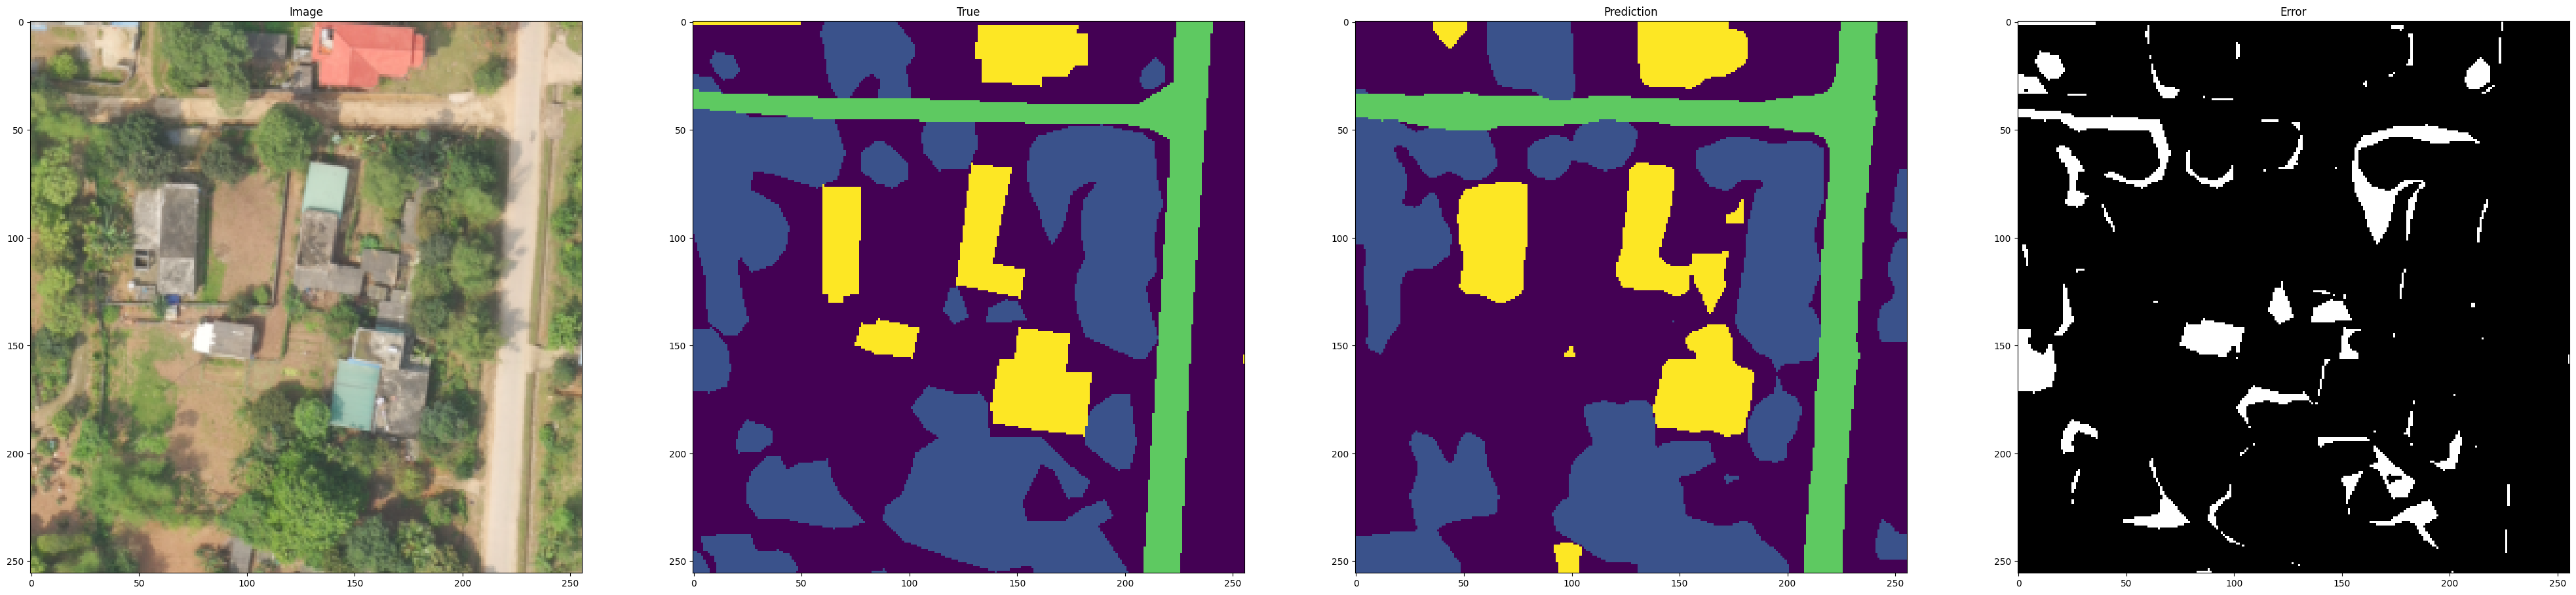

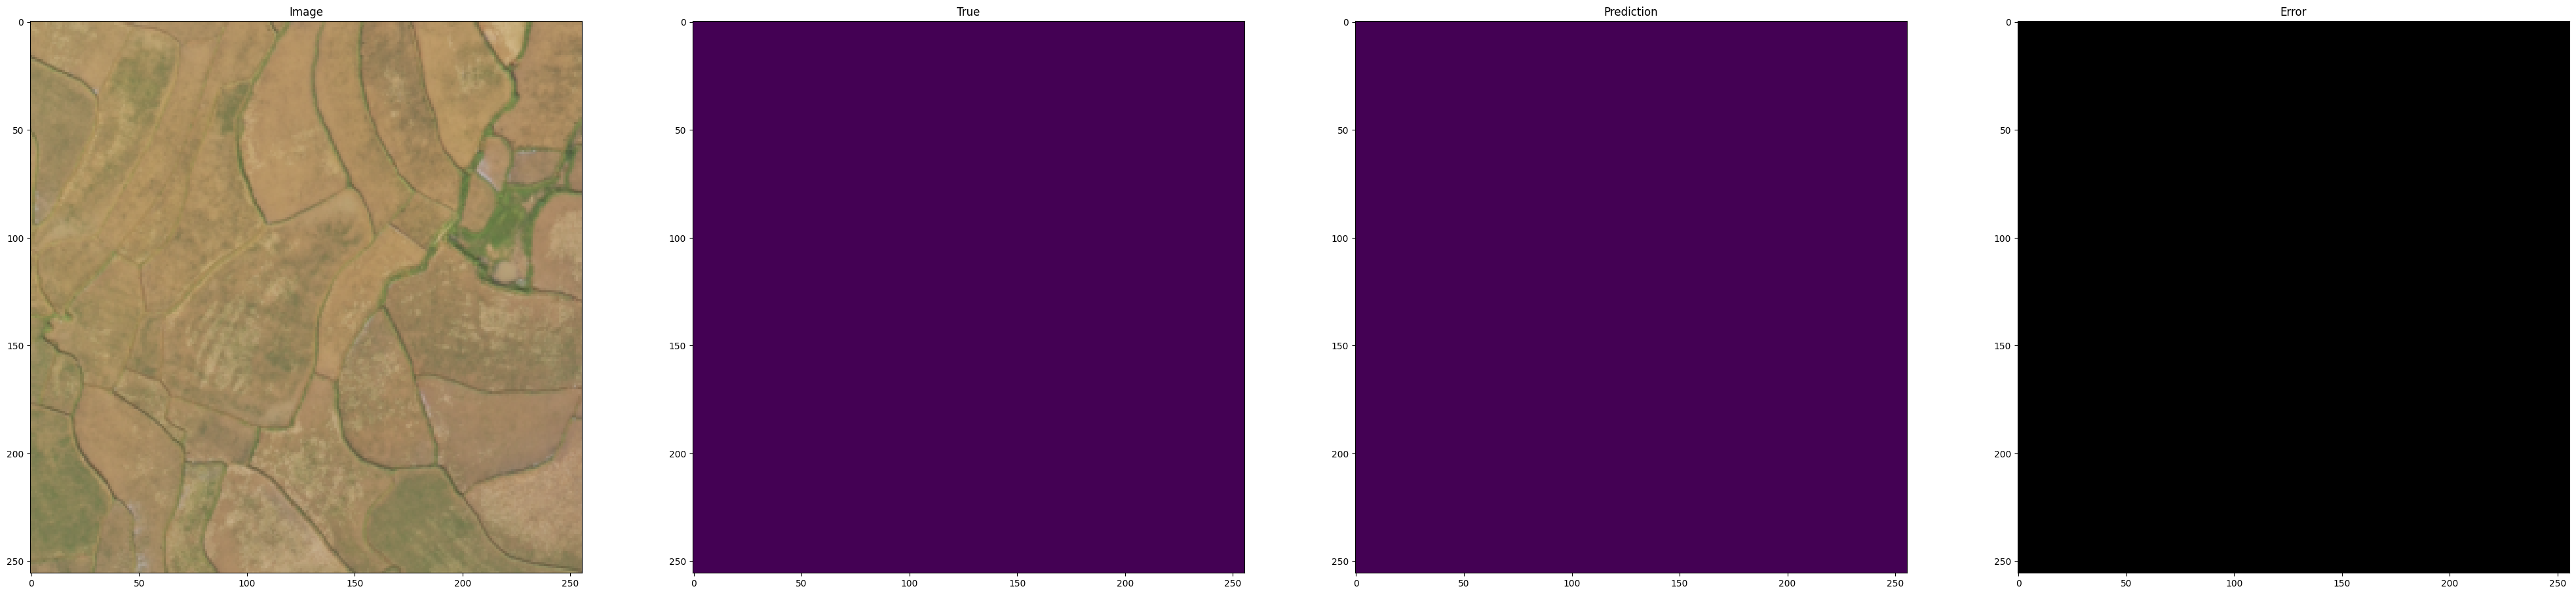

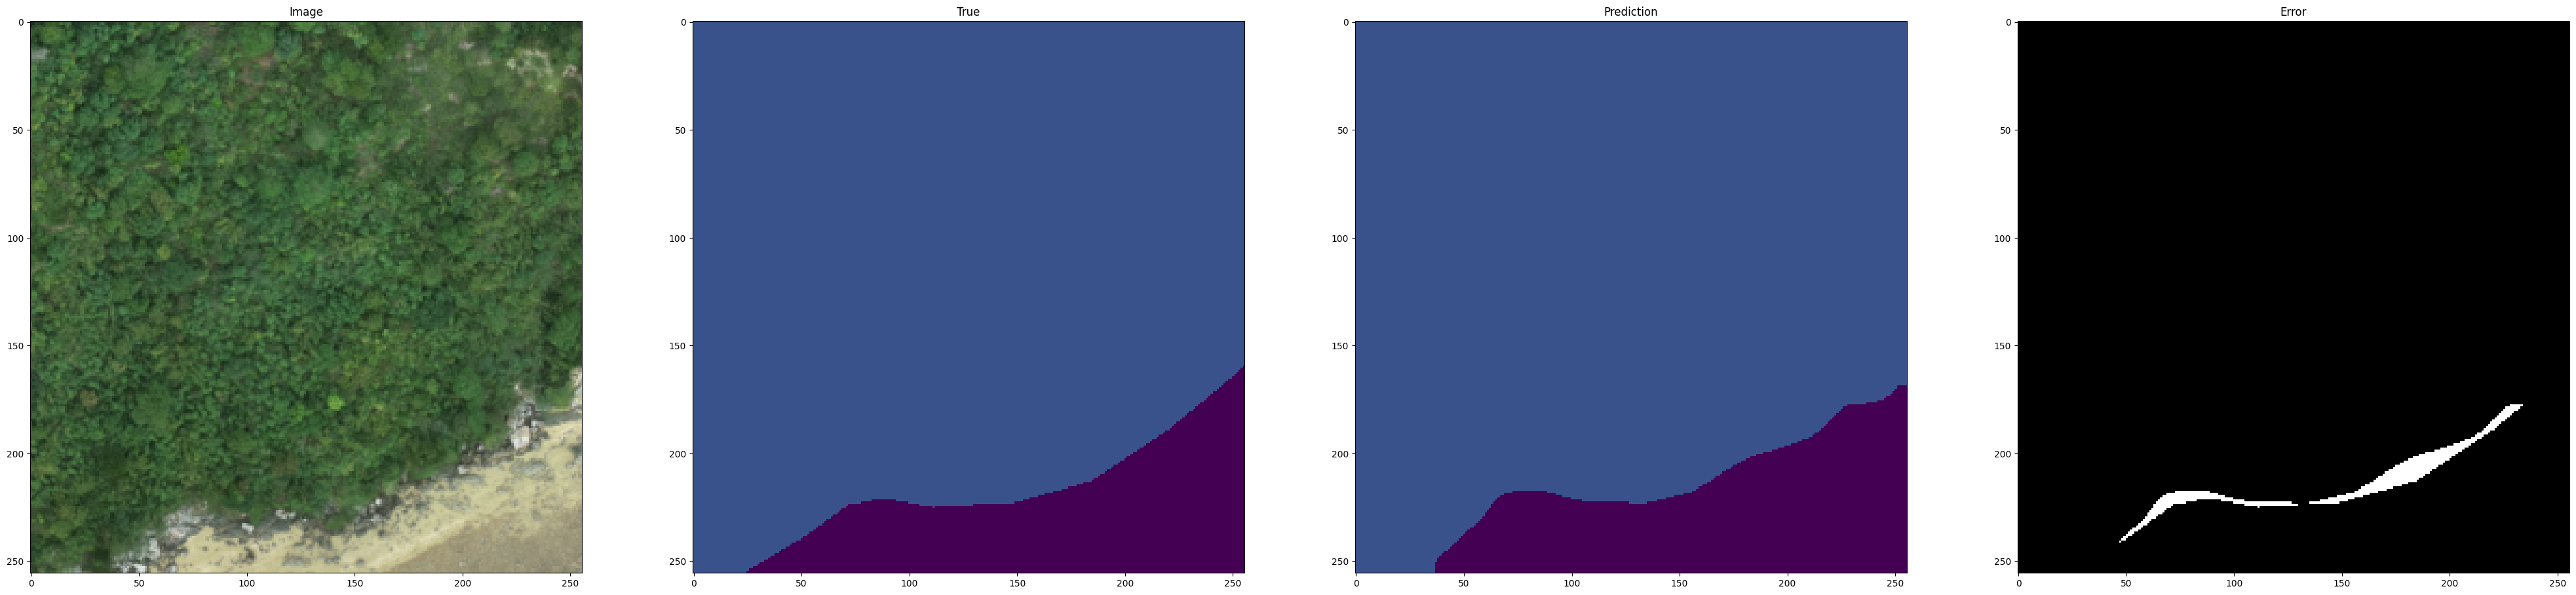

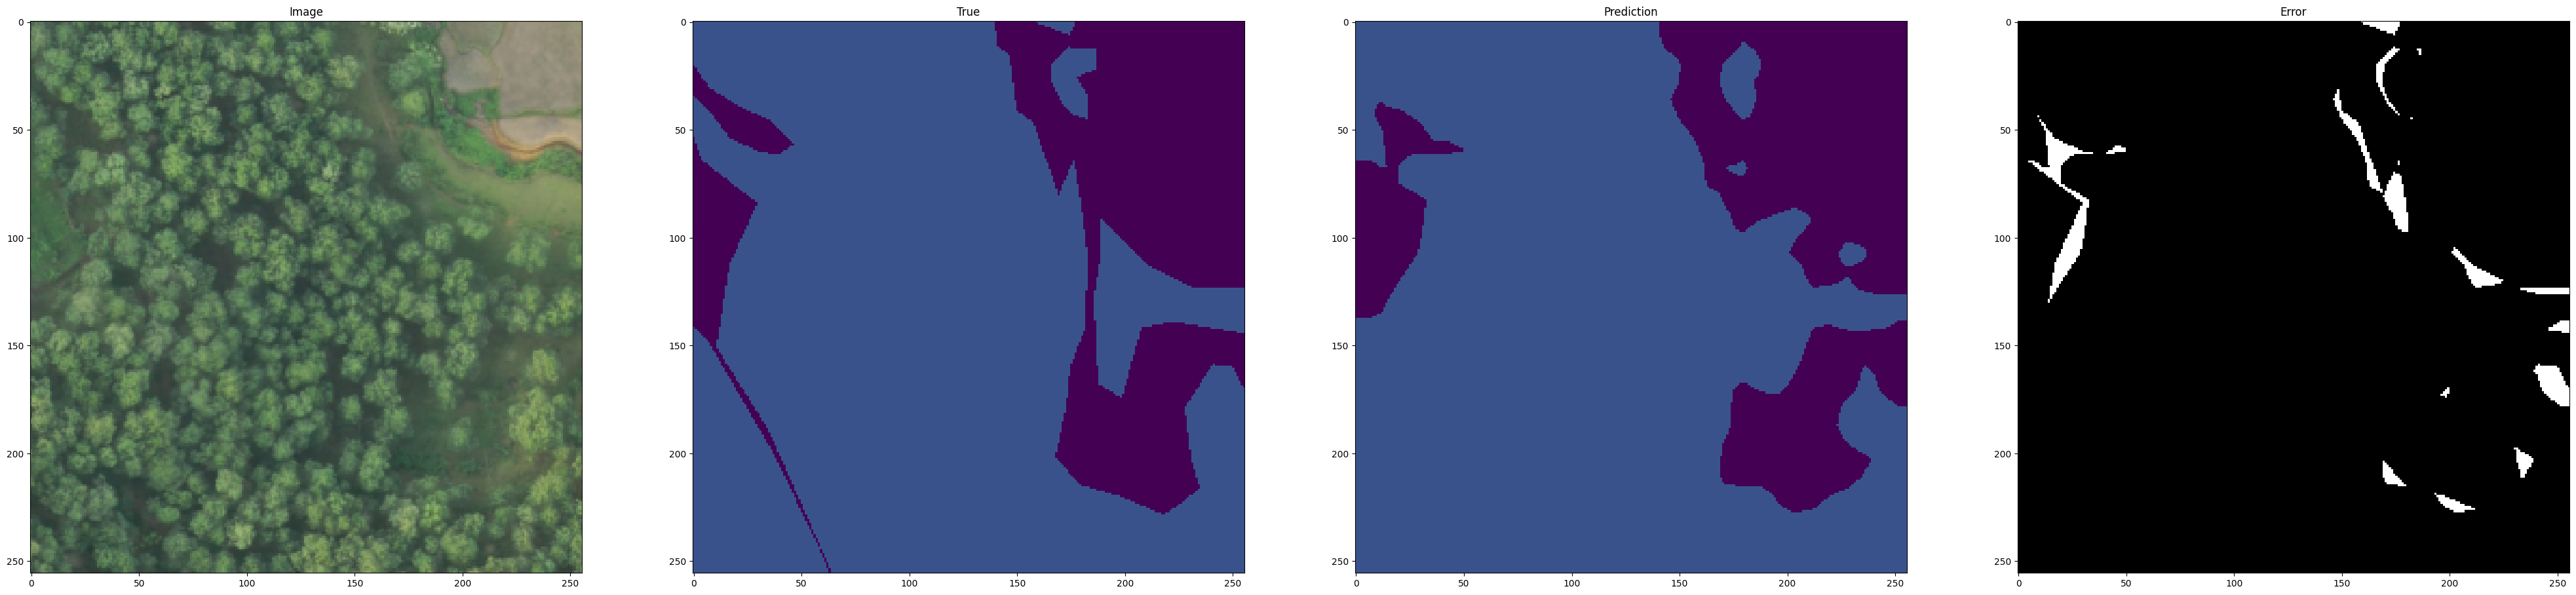

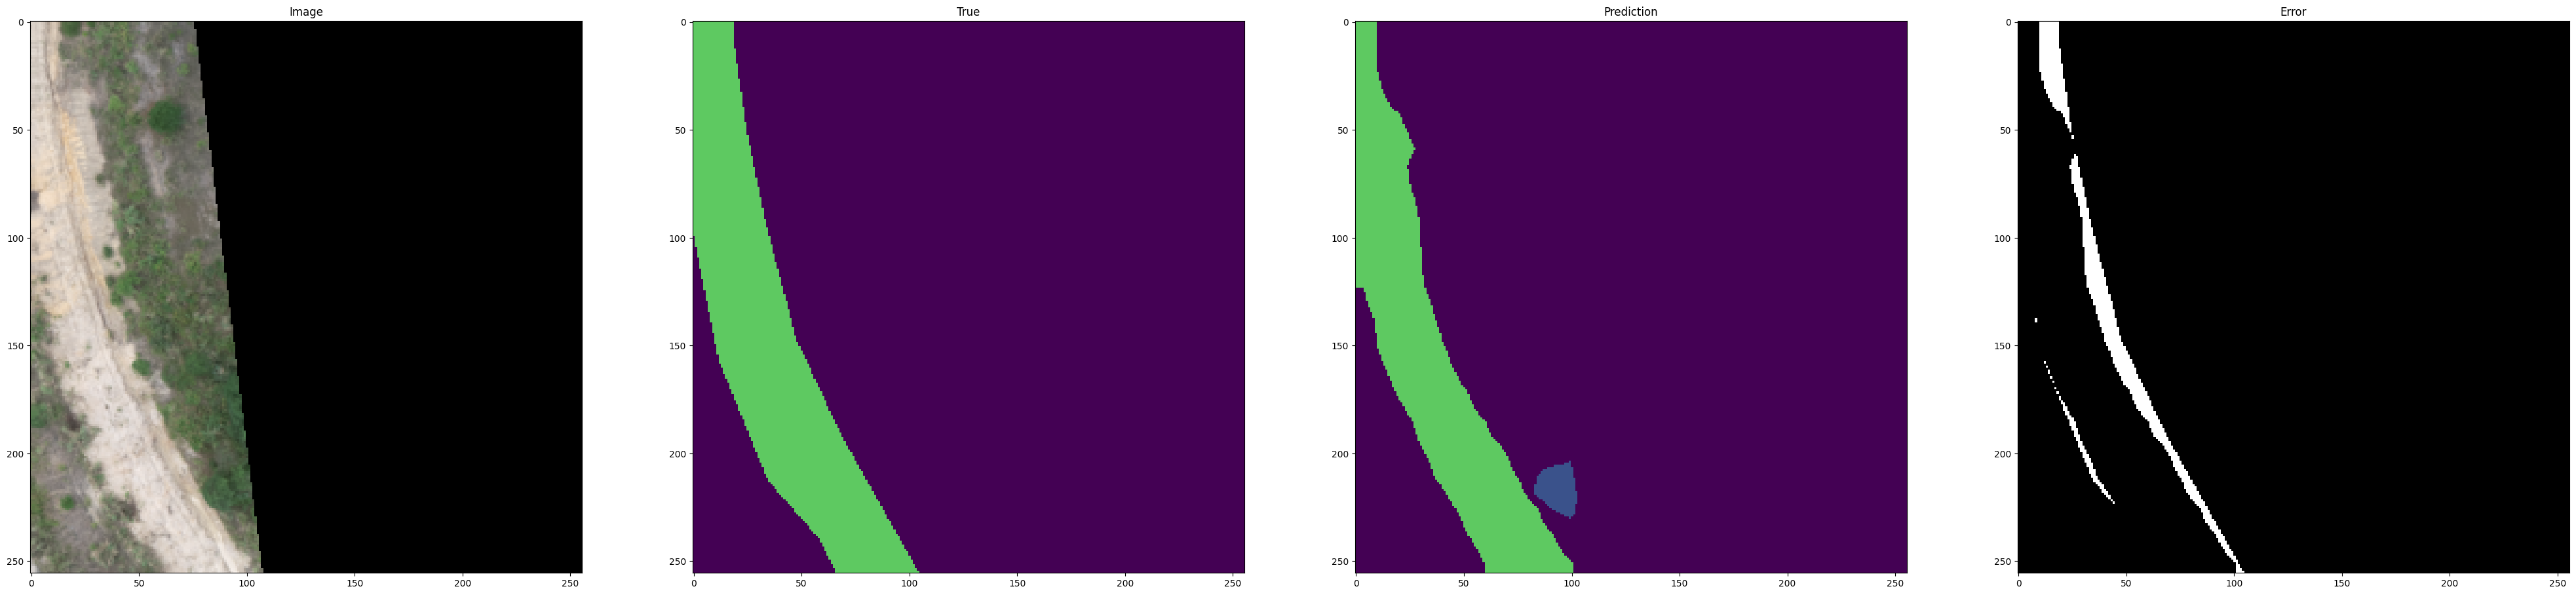

In [18]:
vmin = 0
vmax = 4

for i in range(15):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes

    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype('uint8')
    plt.imshow(error, cmap='gray')


In [12]:
# prediction = model.predict(np.expand_dims(X_test[1], 0))
# print(prediction.shape)
# print(prediction)

In [13]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


In [14]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

In [15]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [16]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8751049164370784
IoU for class 1 : 0.8896751019302673
IoU for class 2 : 0.9265078838777537
IoU for class 3 : 0.6282640018322186
IoU for class 4 : 0.7397014267097233


In [17]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.8118506661574083
